In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import re
import glob
from scipy import stats
from keras.models import Sequential
from keras.callbacks import History 
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
#from matplotlib import pyplot

# Load Dataset

Load Dataset, concatenate data and count Rows and Columns

In [2]:
# Download dataset from Github and unzip
!wget 'https://github.com/cargilgar/Smart-Alarm-using-tinyML/raw/main/dataset/dataset-1-15.zip'

!unzip dataset-1-15.zip

--2021-06-08 12:38:59--  https://github.com/cargilgar/Smart-Alarm-using-tinyML/raw/main/dataset/dataset-1-15.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cargilgar/Smart-Alarm-using-tinyML/main/dataset/dataset-1-15.zip [following]
--2021-06-08 12:38:59--  https://raw.githubusercontent.com/cargilgar/Smart-Alarm-using-tinyML/main/dataset/dataset-1-15.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1075278 (1.0M) [application/zip]
Saving to: ‘dataset-1-15.zip’

dataset-1-15.zip    100%[===================>]   1.03M  --.-KB/s    in 0.05s   

2021-06-08 12:39:00 (21.1 MB/s) - ‘dataset-1-15

In [3]:
#Create full dataframe with all subject csv's concatenated
path = r'content/output/'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    subject_csv = pd.read_csv(filename, index_col=None, header=0)
    li.append(subject_csv)

df = pd.concat(li, axis=0, ignore_index=True)

#Save big dataframe as CSV
df.to_csv('big_df.csv')

#Rows and Columns
total_rows=len(df.axes[0]) #===> Axes of 0 is for a row
total_cols=len(df.axes[1]) #===> Axes of 1 is for a column
print("Number of Rows: "+str(total_rows))
print("Number of Columns: "+str(total_cols))

Number of Rows: 51376
Number of Columns: 6


# Labels
stage (0-5, wake = 0, N1 = 1, N2 = 2, N3 = 3, REM = 5)

In [4]:
#Show labels
# Same labels will be reused throughout the program

df['Labels'].describe()
#subject_csv.hist('Heart Rate')
#subject_csv.describe()

df['Labels'] = df['Labels'].map({0:0,1:1,2:1,3:1,5:2,},na_action=None)

# Wake --> 0
# NREM --> 1
# REM --> 2
#Not labeled values --> NaN

#Delete non-labeled Rows
df.dropna(inplace=True)

#df

# Normalize Training Data
Next, we need to normalize our features within our training data. Of course there are various ways on how to normalize. Please keep in mind that you use the same normalization algorithm later when feeding new data into your neural network. Otherwise your preditions will be off. On top of the normalization we will also apply rounding to the three features.

In [5]:
# Normalize features for training data set (values between 0 and 1)***
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df['X'] = df['X'] / df['X'].max()
df['Y'] = df['Y'] / df['Y'].max()
df['Z'] = df['Z'] / df['Z'].max()
df['Heart Rate'] = df['Heart Rate'] / df['Heart Rate'].max()

# Round numbers (4 decimals)
df = df.round({'X': 4, 'Y': 4, 'Z': 4, 'Heart Rate': 4})

df

,Time,X,Y,Z,Heart Rate,Labels
85,1375.0,0.2232,0.2200,0.5648,0.5154,0.0
86,1390.0,0.2232,0.2184,0.5653,0.5051,0.0
87,1405.0,0.2241,0.2179,0.5669,0.5103,0.0
88,1420.0,0.2254,0.2014,0.5721,0.5256,0.0
89,1435.0,0.2303,0.1418,0.5870,0.5269,0.0
...,...,...,...,...,...,...
51371,13847.0,0.2196,0.0861,0.5935,0.6000,1.0
51372,13862.0,0.2210,0.0881,0.5953,0.6154,1.0
51373,13877.0,0.2199,0.0851,0.5944,0.6333,1.0
51374,13892.0,0.2199,0.0848,0.5947,0.6103,1.0


# Split Dataset
Train, Validation and Test

Split the data
We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

***ANOTHER SPLITING OPTION WOULD BE TO SEPARATE USERS (Crear nueva columna con nombre usuario?? O manejar cada CSV por separado??)***





In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}

PERCENTAGE_TRAIN = 0.7
PERCENTAGE_VALIDATION = 0.2

n = len(df)
train_df = df[0:int(n*PERCENTAGE_TRAIN)]
val_df = df[int(n*PERCENTAGE_TRAIN):int(n*(PERCENTAGE_VALIDATION + PERCENTAGE_TRAIN))]
test_df = df[int(n*(PERCENTAGE_VALIDATION + PERCENTAGE_TRAIN)):]

num_features = df.shape[1]

test_df

,Time,X,Y,Z,Heart Rate,Labels
46304,18870.0,0.1334,0.5631,0.3353,0.4692,0.0
46305,18885.0,0.1346,0.5562,0.3327,0.4538,0.0
46306,18900.0,0.1343,0.5562,0.3328,0.4590,0.0
46307,18915.0,0.2505,0.5931,0.4310,0.4538,0.0
46308,18930.0,0.1702,0.4961,0.4041,0.4654,0.0
...,...,...,...,...,...,...
51371,13847.0,0.2196,0.0861,0.5935,0.6000,1.0
51372,13862.0,0.2210,0.0881,0.5953,0.6154,1.0
51373,13877.0,0.2199,0.0851,0.5944,0.6333,1.0
51374,13892.0,0.2199,0.0848,0.5947,0.6103,1.0


# Reshape Data into Segments and Prepare for Keras
The data contained in the dataframe is not ready yet to be fed into a neural network. Therefore we need to reshape it. Let’s create another function for this called “create_segments_and_labels”. This function will take in the dataframe and the label names (the constant that we have defined at the beginning) as well as the length of each record. In our case, let’s go with 80 steps (see constant defined earlier). Taking into consideration the 20 Hz sampling rate, this equals to 4 second time intervals (calculation: 0.05 * 80 = 4). Besides reshaping the data, the function will also separate the features (x-acceleration, y-acceleration, z-acceleration) and the labels (associated activity). https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0

In [8]:
def create_segments_and_labels(dfs,labels):

    labels = dfs[labels]
    #segments = dfs[['Z','Heart Rate']]
    segments = dfs[['X','Y','Z','Heart Rate']] #All features

    return segments, labels

In [9]:
# x_train --> Features
# y_train --> Labels
   
x_train, y_train = create_segments_and_labels(train_df,'Labels')
x_val, y_val = create_segments_and_labels(val_df,'Labels')
x_test, y_test = create_segments_and_labels(test_df,'Labels')


In [10]:
print(x_train.shape[0], 'training samples')
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
x_train.shape[0]
#x_train

34904 training samples
x_train shape:  (34904, 4)
y_train shape:  (34904,)


34904

# Create Deep Neural Network Model in Keras


In [11]:
# define the keras model
num_classes = 3

#Needed to categorical_crossentropy loss function
#y_train = to_categorical(y_train)
#y_val = to_categorical(y_val)
#y_test = to_categorical(y_test)

model = Sequential()
model.add(Dense(45, input_dim= x_train.shape[1], activation='relu'))
#model.add(Dense(30, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))#Last layer corresponds with the number of possible outputs

# compile the keras model
opt = SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss= 'sparse_categorical_crossentropy', optimizer= opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 45)                225       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 138       
Total params: 363
Trainable params: 363
Non-trainable params: 0
_________________________________________________________________


# Train Model

In [12]:
# fit the keras model on the dataset
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=40, batch_size=72, verbose=1)

Epoch 1/40
485/485 [==============================] - 15s 3ms/step - loss: 0.8399 - accuracy: 0.6670 - val_loss: 0.7833 - val_accuracy: 0.6875
Epoch 2/40
485/485 [==============================] - 1s 2ms/step - loss: 0.8081 - accuracy: 0.6891 - val_loss: 0.7819 - val_accuracy: 0.6875
Epoch 3/40
485/485 [==============================] - 1s 2ms/step - loss: 0.8115 - accuracy: 0.6852 - val_loss: 0.7802 - val_accuracy: 0.6875
Epoch 4/40
485/485 [==============================] - 1s 2ms/step - loss: 0.8081 - accuracy: 0.6863 - val_loss: 0.7819 - val_accuracy: 0.6875
Epoch 5/40
485/485 [==============================] - 1s 2ms/step - loss: 0.8027 - accuracy: 0.6890 - val_loss: 0.7838 - val_accuracy: 0.6875
Epoch 6/40
485/485 [==============================] - 1s 2ms/step - loss: 0.8037 - accuracy: 0.6885 - val_loss: 0.7783 - val_accuracy: 0.6875
Epoch 7/40
485/485 [==============================] - 1s 2ms/step - loss: 0.8024 - accuracy: 0.6885 - val_loss: 0.7784 - val_accuracy: 0.6875
Epoch

# Evaluate Model on Test Data

In [13]:
# evaluate the keras model

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

156/156 [==============================] - 0s 1ms/step - loss: 0.7331 - accuracy: 0.7560
Test accuracy 0.755965530872345
Test loss 0.7331000566482544


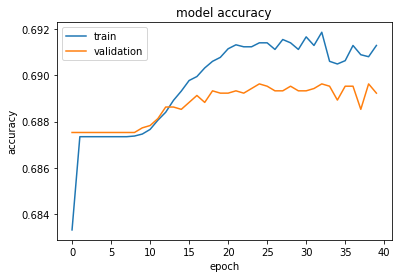

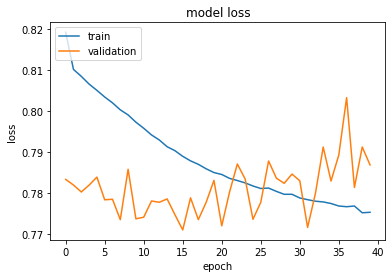

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



---



---



---




---



---



---



---



---



---



---



---



---


---



---



---



---



---


---



---



---



---




Shuffle the training set because we will be using the validation_split option later when training.

In [ ]:
'''idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]